<a href="https://colab.research.google.com/github/phaneo/TF2-Complete/blob/main/04_Transfer_Learning_with_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Extraction

In [ ]:
import tensorflow as tf


## Downloading and exploring the data

In [ ]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zipref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zipref.extractall()
zipref.close()

--2022-08-08 06:08:25--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 173.194.202.128, 108.177.98.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   245MB/s    in 0.7s    

2022-08-08 06:08:25 (245 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent/"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in 10_food_classes_10_percent/
There are 10 directories and 0 images in 10_food_classes_10_percent/train
There are 0 directories and 75 images in 10_food_classes_10_percent/train/pizza
There are 0 directories and 75 images in 10_food_classes_10_percent/train/grilled_salmon
There are 0 directories and 75 images in 10_food_classes_10_percent/train/hamburger
There are 0 directories and 75 images in 10_food_classes_10_percent/train/steak
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_curry
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ramen
There are 0 directories and 75 images in 10_food_classes_10_percent/train/sushi
There are 0 directories and 75 images in 10_food_classes_10_percent/train/fried_rice
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_wings
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ice_cream
There are 10 directo

## Creating dataloaders (preparing data)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

print("Training images: ")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size = IMG_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode = 'categorical')

print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = IMG_SHAPE,
                                             batch_size = BATCH_SIZE,
                                             class_mode = 'categorical')

Training images: 
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks

Some of the most popular callbacks:
* Tracking experiments with Tensorboard callback
* Model experiment with the ModelCheckpoint callback
* Stopping a model from training with the EarlyStopping callback

In [ ]:
# Create Tensorboard callback

import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f"Saving Tensorboard log files to: {log_dir}")
  return tensorboard_callback
  

## Creating models using TF Hub


In [ ]:
# Let's compare the following two models

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

In [ ]:
# Import dependencies

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# Let's make a create_model function to create a model from a url

def create_model(model_url, num_classes = 10):
  """
  Takes a TF Hub URL and creates a Keras Sequential model
  
  Args:
    model_url (str): A Tensorflow Hub Feature Extraction URL
    num_classes (int): No. of output neurons in the output layer,
      should be equal to no. of target classes, default 10.
  
  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes output neurons.
  """

  # Download pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable = False,
                                           name = "feature_extraction_layer",
                                           input_shape = IMG_SHAPE + (3,))
  
  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(10, activation = "softmax", name = "output_layer")
  ])
  return model


### Creating and testing ResNet model

In [ ]:
# Create ResNet model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
resnet_model.compile(loss = "categorical_crossentropy",
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ["accuracy"])

history_resnet = resnet_model.fit(train_data_10_percent,
                                  epochs = 5,
                                  steps_per_epoch = len(train_data_10_percent),
                                  validation_data = test_data,
                                  validation_steps = len(test_data),
                                  callbacks = (create_tensorboard_callback(dir_name="10_food_classes_10_percent/Tensorboard",
                                                                           experiment_name="ResNet")))

Saving Tensorboard log files to: 10_food_classes_10_percent/Tensorboard/ResNet/20220808-060838
Epoch 1/5
24/24 [==============================] - 32s 745ms/step - loss: 1.7996 - accuracy: 0.4147 - val_loss: 1.1572 - val_accuracy: 0.6320
Epoch 2/5
24/24 [==============================] - 16s 693ms/step - loss: 0.8823 - accuracy: 0.7413 - val_loss: 0.8571 - val_accuracy: 0.7352
Epoch 3/5
24/24 [==============================] - 16s 706ms/step - loss: 0.6181 - accuracy: 0.8200 - val_loss: 0.7468 - val_accuracy: 0.7572
Epoch 4/5
24/24 [==============================] - 16s 671ms/step - loss: 0.4627 - accuracy: 0.8773 - val_loss: 0.6974 - val_accuracy: 0.7796
Epoch 5/5
24/24 [==============================] - 16s 670ms/step - loss: 0.3719 - accuracy: 0.9147 - val_loss: 0.6611 - val_accuracy: 0.7872


In [ ]:
#!tensorboard dev upload --logdir 10_food_classes_10_percent/Tensorboard/ResNet/20220807-105441/

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_loss_curves(history):
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  acc = history.history["accuracy"]
  val_acc = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  plt.figure()
  plt.plot(epochs, loss, label = "training loss")
  plt.plot(epochs, val_loss, label = "val loss")
  plt.title("Loss")
  plt.xlabel("epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, acc, label = "training accuracy")
  plt.plot(epochs, val_acc, label = "val accuracy")
  plt.title("Accuracy")
  plt.xlabel("epochs")
  plt.legend()

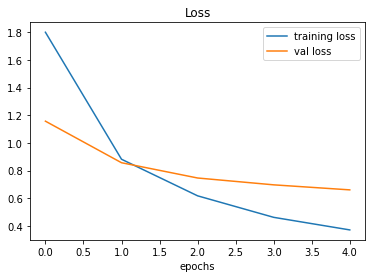

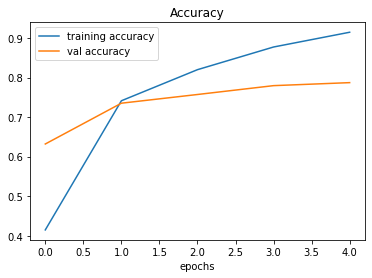

In [ ]:
plot_loss_curves(history_resnet)

### Creating and testing EfficientNet model

In [ ]:
effnet_model = create_model(model_url = efficientnet_url,
                            num_classes=10)
effnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
effnet_model.compile(loss = "categorical_crossentropy",
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ["accuracy"])

effnet_history = effnet_model.fit(train_data_10_percent,
                                  epochs = 5,
                                  steps_per_epoch = len(train_data_10_percent),
                                  validation_data = test_data,
                                  validation_steps = len(test_data),
                                  callbacks = [create_tensorboard_callback(dir_name='10_food_classes_10_percent/Tensorboard',
                                                                           experiment_name = 'EfficientNet')])

Saving Tensorboard log files to: 10_food_classes_10_percent/Tensorboard/EfficientNet/20220808-061332
Epoch 1/5
24/24 [==============================] - 26s 720ms/step - loss: 1.8161 - accuracy: 0.4627 - val_loss: 1.2854 - val_accuracy: 0.7296
Epoch 2/5
24/24 [==============================] - 16s 680ms/step - loss: 1.0438 - accuracy: 0.7813 - val_loss: 0.8625 - val_accuracy: 0.8196
Epoch 3/5
24/24 [==============================] - 16s 683ms/step - loss: 0.7509 - accuracy: 0.8333 - val_loss: 0.6928 - val_accuracy: 0.8444
Epoch 4/5
24/24 [==============================] - 24s 1s/step - loss: 0.6035 - accuracy: 0.8733 - val_loss: 0.6071 - val_accuracy: 0.8548
Epoch 5/5
24/24 [==============================] - 15s 643ms/step - loss: 0.5113 - accuracy: 0.8933 - val_loss: 0.5511 - val_accuracy: 0.8644


In [ ]:
#!tensorboard dev upload --logdir "10_food_classes_10_percent/Tensorboard/EfficientNet/"

Upload started and will continue reading any new data as it's added to the logdir.

To stop uploading, press Ctrl-C.

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/SnnUK3r7T3yASKbcqWq2EQ/

[2022-08-08T06:15:12] Started scanning logdir.
[2022-08-08T06:15:13] Total uploaded: 30 scalars, 0 tensors, 1 binary objects (3.9 MB)


Interrupted. View your TensorBoard at https://tensorboard.dev/experiment/SnnUK3r7T3yASKbcqWq2EQ/
^C


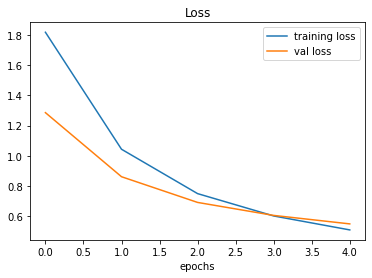

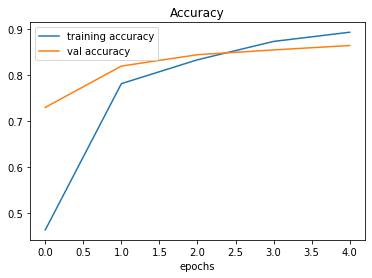

In [ ]:
plot_loss_curves(effnet_history)

## Different types of Transfer Learning

1. **As-is**: Using an existing model with no changes at all
2. **Feature extraction**: Use the prelearned patterns of an existing model and adjust the output layer for the relevant problem
3. Fine-tuning transfer learning: Use the prelearned patterns of an existing model and fine-tune many/all of the underlying layers (incl. new output layers).

## Comparing our models using Tensorboard

In [ ]:
!tensorboard dev upload --logdir 10_food_classes_10_percent/Tensorboard/ \
  --name "EfficientNetB0 vs ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models using EfficientNet and ResNet" \
  --one_shot


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/QqMe43TJQBSgCOZL61vmDg/

[2022-08-08T06:15:50] Started scanning logdir.
[2022-08-08T06:15:53] Total uploaded: 60 scalars, 0 tensors, 2 binary objects (5.5 MB)
[2022-08-08T06:15:53] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/QqMe43TJQBSgCOZL61vmDg/


In [ ]:
!tensorboard dev list

No experiments. Use `tensorboard dev upload` to get started.


In [ ]:
!tensorboard dev delete --experiment_id 2pLAKEowQkOGsYG3alNERg

Deleted experiment 2pLAKEowQkOGsYG3alNERg.
